In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

2024-11-24 22:36:48.801042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 22:36:48.836716: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 22:36:48.848596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 22:36:48.919078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [16]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [11]:
print(f"Train Image Size: {train_images.shape}")
print(f"Train label Size: {train_labels.shape}")

print(f"Test Image Size: {test_images.shape}")
print(f"Test label Size: {test_labels.shape}")

Train Image Size: (60000, 28, 28)
Train label Size: (60000,)
Test Image Size: (10000, 28, 28)
Test label Size: (10000,)


## Data Exploration

In [12]:
print(f"Min value: {train_images[0].min()}\nMax Value: {train_images[0].max()}")

Min value: 0
Max Value: 255


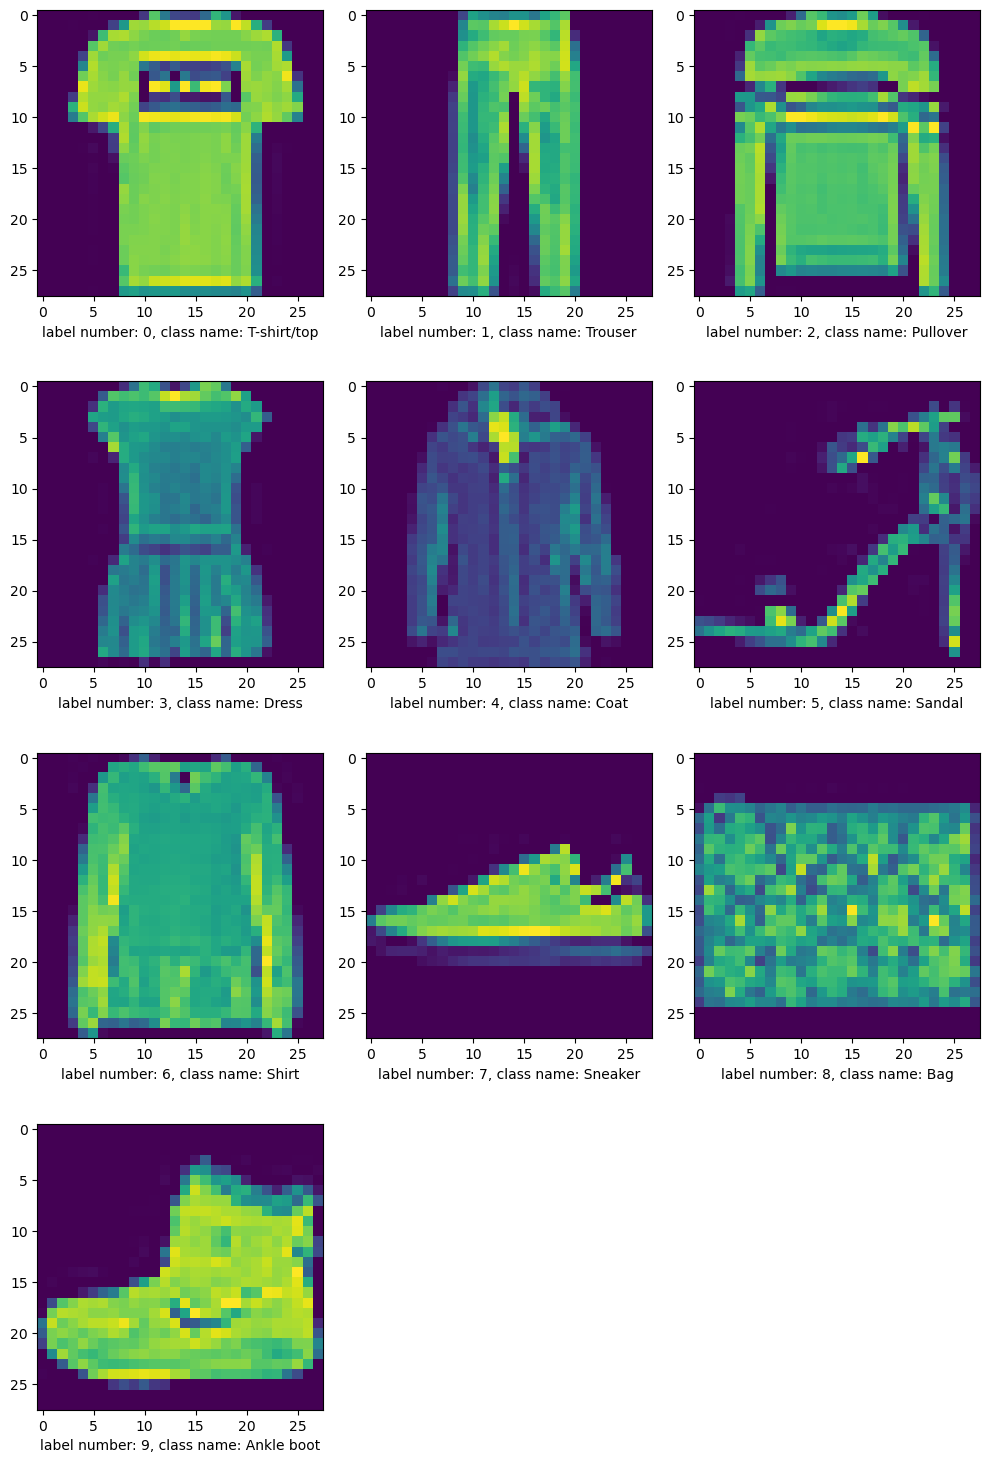

In [17]:
# Plotting images for each labels
unique_values, indices = np.unique(train_labels, return_index=True)

fig, axs= plt.subplots(4, 3, figsize=(10, 15))
axs= axs.flatten()
for (unique_value, index) in (zip(unique_values, indices)):
    axs[unique_value].imshow(train_images[index])
    axs[unique_value].set_xlabel(f"label number: {unique_value}, class name: {class_names[unique_value]}")

# Leave the last two plots empty
for i in range(10, 12):  # Optional: Remove axes
    axs[i].axis('off')


plt.tight_layout()
plt.show()

In [18]:
#Identify the count of images of each categories.
# np.c(train_labels)
import pandas as pd
unique_values, counts = np.unique(train_labels, return_counts=True)

train_image_label_df = pd.DataFrame( data = {'Categories Name': class_names, 'Label Id':unique_values, "Count": counts})
train_image_label_df

,Categories Name,Label Id,Count
0,T-shirt/top,0,6000
1,Trouser,1,6000
2,Pullover,2,6000
3,Dress,3,6000
4,Coat,4,6000
5,Sandal,5,6000
6,Shirt,6,6000
7,Sneaker,7,6000
8,Bag,8,6000
9,Ankle boot,9,6000


In [19]:
#Normalization in the range of [0 - 1]
train_images = train_images / 255.0

test_images = test_images / 255.0

In [ ]:
# One hot encoding, 
encoder = OneHotEncoder(sparse_output= False)
records
train_labels_onehot = encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels_onehot = encoder.transform(test_labels.reshape(-1, 1))

- If we want to use one hot encoded label data then we must use **Categorical Cross Entropy** as loss function. 
- If we use normal label data then we can use **Sparce Categorical Cross Entropy** as loss function.

# Model Building And Evaluation:

In [21]:
# Checking whether GPU or CPU used for model training
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("TensorFlow is using the CPU.")
else:
    print(f"TensorFlow is using the following GPU(s): {gpu_devices}")

TensorFlow is using the following GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1732509541.639419  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732509541.824017  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732509541.824282  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [22]:
# This is done for the reproducability of the model
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Common Methods Used In Model Evaluations

In [24]:
# Method to plot train and validation accuracy and loss over epoches.
def PlotTrainAndValidationAccuracyAndLoss(nn_model_history: tf.keras.callbacks.History, model_name: str):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['accuracy'], label='Train', ax = axs[0])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_accuracy'], label='Validation', ax = axs[0])
    axs[0].set_title(f'{model_name} accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epoch')
    axs[0].legend(loc='upper left')

    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['loss'], label='Train', ax = axs[1])
    sns.lineplot(x=np.array(nn_model_history.epoch) + 1, y= nn_model_history.history['val_loss'], label='Validation', ax = axs[1])
    axs[1].set_title(f'{model_name} loss')
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [32]:
#Model Evaluation function
def EvaluateNeuralNetworkModel(nn_model : tf.keras.Sequential, test_images: np.ndarray, test_labels: np.ndarray, test_labels_onehot: np.ndarray, model_name: str):
    model_test_loss, model_test_acc = nn_model.evaluate(test_images,  test_labels_onehot, verbose=2)

    print(f'\nTest accuracy for {model_name}: {model_test_acc:.4f}\n')
    print(f"Test loss for {model_name}: {model_test_loss:.4f}\n")
    
    model_prediction_result_softmax= nn_model.predict(test_images,batch_size= 32)

    model_test_label_pred = np.argmax(model_prediction_result_softmax, axis=1)  # Predicted labels

    print(f"first 10 predicted outputs: {model_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for neural network classification model
    model_classification_report = (classification_report(test_labels, model_test_label_pred))
    print(f"Classification report for {model_name} :\n{model_classification_report}")

    # Print a confusion matrix for neural network on test dataset

    model_confusion_matrix= (confusion_matrix(test_labels, model_test_label_pred))

    sns.heatmap(data= model_confusion_matrix,fmt='g', annot= True, cmap= "crest")
    plt.title(f"Confusion Matrix for the {model_name} on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    return model_prediction_result_softmax
    

In [26]:
# Model committee by averaging prediction of models: 
def ModelCommitteeAnalysis(model_result_softmax_list: list, test_labels: np.ndarray, model_name: str, is_object_return= False):
    model_committee_softmax = np.mean(model_result_softmax_list, axis= 0)
    model_committee_test_label_pred = np.argmax(model_committee_softmax, axis=1)  # Predicted labels

    loss = tf.keras.losses.CategoricalCrossentropy()(test_labels_onehot, model_committee_softmax).numpy()
    accuracy = accuracy_score(test_labels, model_committee_test_label_pred)

    print(f"Loss for the {model_name} neural network committee on test dataset: {loss:.4f}")
    print(f"Accuracy for the {model_name} neural network committee on test dataset: {accuracy:.4f}")

    print(f"first 10 predicted outputs using committee by averaging predictions: {model_committee_test_label_pred[:10]}\n")
    print(f"first 10 true outputs: {test_labels[:10]}\n")

    # Print a classification report for committee of shallow neural network classification models
    model_committee_classification_report = (classification_report(test_labels, model_committee_test_label_pred))
    print(model_committee_classification_report)

    # Print a confusion matrix for committee of neural network on test dataset

    model_committee_confusion_matrix= (confusion_matrix(test_labels, model_committee_test_label_pred))

    sns.heatmap(data= model_committee_confusion_matrix,fmt='g', annot= True, cmap= "vlag")
    plt.title(f"Confusion Matrix for the {model_name} neural network committee on test dataset")
    plt.tight_layout()
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.show()

    if(is_object_return):
        return model_committee_softmax, model_committee_test_label_pred


## Shallow Neural Network

### shallow neural network 1

**Model Architecture**:
- 28 * 28 pixels images are provided as input to the model. 
- First step is to flatten the 2D inputs into 1D input parameters. 
- After Flatten, It is fed to the fist Dense layer. It contains 128 neurons and **relu** as activation function.
- It has output layers with 10 neurons. **Softmax** activation function is used in output layer.
- For the optimization of the model, We are using **ADAM** optimizer.
- For the loss calculation of the model, We are using **Categorical** Cross Entropy*.
- As an additional performance metrices, we are using **Accuracy** to evaluate the model during training. 

In [27]:
#Shallow Neural Network Model 1
shallow_nn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn1_history = shallow_nn_model1.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 32)

I0000 00:00:1732509581.332613  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732509581.332918  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732509581.333104  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732509581.416764  415964 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/100


I0000 00:00:1732509583.088526  416527 service.cc:146] XLA service 0x7b87bc0073a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732509583.088549  416527 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-24 22:39:43.104831: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-24 22:39:43.198137: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 154/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6012 - loss: 1.1440

I0000 00:00:1732509583.849334  416527 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7702 - loss: 0.6579 - val_accuracy: 0.8467 - val_loss: 0.4291
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8600 - loss: 0.3970 - val_accuracy: 0.8586 - val_loss: 0.3885
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8715 - loss: 0.3530 - val_accuracy: 0.8650 - val_loss: 0.3721
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8826 - loss: 0.3260 - val_accuracy: 0.8689 - val_loss: 0.3629
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8878 - loss: 0.3059 - val_accuracy: 0.8744 - val_loss: 0.3504
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8952 - loss: 0.2879 - val_accuracy: 0.8740 - val_loss: 0.3578
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8994 - loss: 0.2741 - val_accuracy: 0.8761 - val_loss: 0.3510
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9041 - loss: 0.2604 - val_

Model is trained over 100 epoches and 20% of the training dataset is separated as the validation set. For this model, We used batch size of 32. 

In [29]:
shallow_nn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

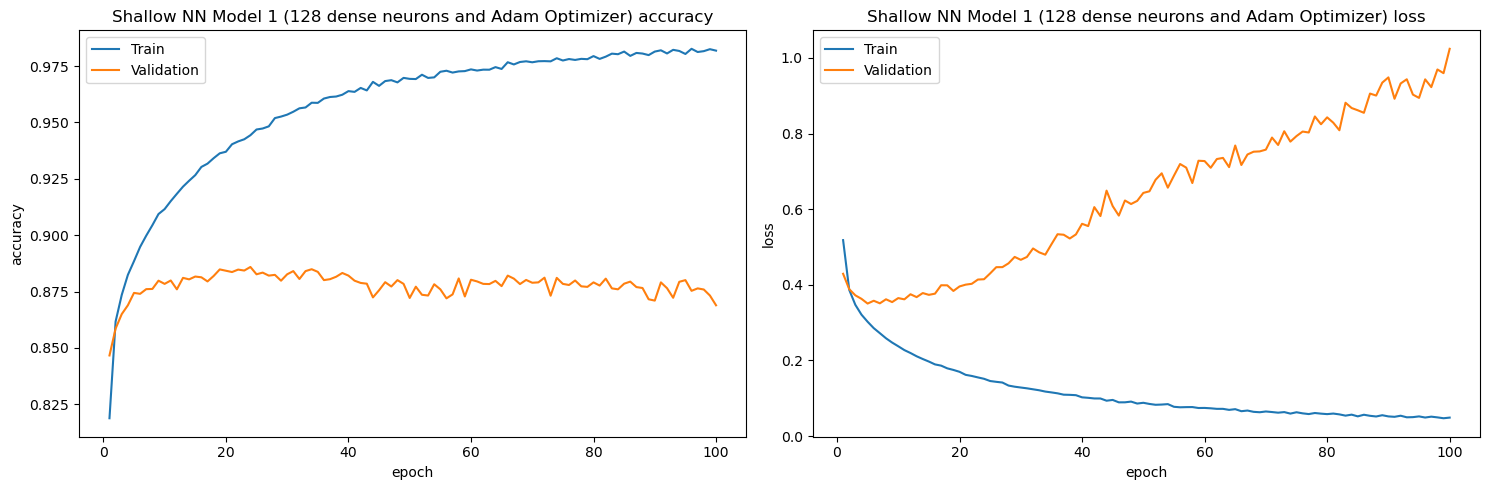

In [45]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn1_history, "Shallow NN Model 1 (128 dense neurons and Adam Optimizer)")


Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - If we look into the accracy of the train data set, it keeps improving over 100 epoches and it reached to the accuracy of 0.9852.
  - But in validation data set, accuracy increased initially but later it did not change over the epoches and maintain the validation accuracy of 0.8698. 
  - There is huge gap in training accuracy and validation accuracy. This is the case of over fitting. Model is able to predict the output accuratly on training dataset but not on validation dataset. 

- **Categorical Cross EntropyLoss**
  - Training loss started from the value of around 0.6569 and it kept decreasing and after around 40 epochs, loss started maintaing similar loss values. And finally at 100 epoches it showed the loss of 0.0425 for training data set. 
  - Similary For the validation dataset, loss values initially decreases but after few epochs it started increasing and after 100 epochs, it had the validation loss of 1.0076. Validation loss has huge deviation from training loss which showed that model is facing the problem of overfitting.

313/313 - 0s - 762us/step - accuracy: 0.8622 - loss: 1.0737

Test accuracy for Shallow Neural Network 1: 0.8622

Test loss for Shallow Neural Network 1: 1.0737

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 1 :
              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1000
           1       0.99      0.96      0.98      1000
           2       0.78      0.73      0.75      1000
           3       0.90      0.84      0.87      1000
           4       0.74      0.83      0.78      1000
           5       0.97      0.95      0.96      1000
           6       0.59      0.73      0.66      1000
           7       0.95      0.95      0.95      1000
           8       0.97      0.95      0.96      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.86     10

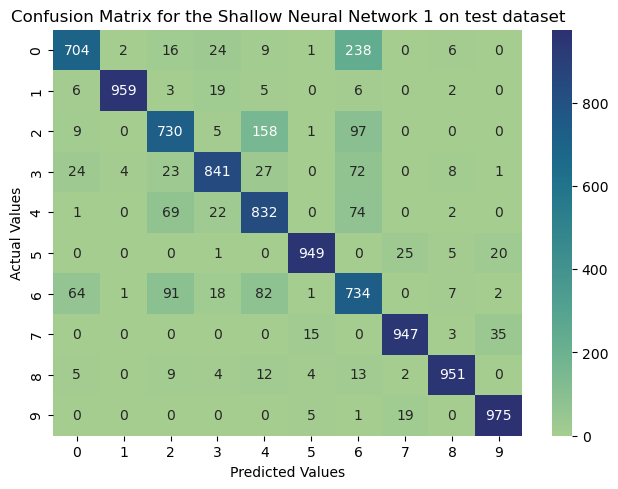

In [34]:
snn1_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model1, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 1")

Class 6 "Shirt" is misclassified for the most of the time. It is mostly confused with class 0 "T-shirt/top" and then with class 2 "Pullover" and then with class 5 "Coat".

### Shallow Neural Network Model 2

In this model, 
- We used 256 neurons in dense layer with **relu** activation function. 
- We used Adam Optimizer with initial learning rate of 0.001 as the optimization function. 
- While training model we use the batch size of 64. 

Other than that all architectural design is similar to the Shallow Neural Network 1. 

In [ ]:
#Shallow Neural Network Model 2
shallow_nn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn2_history = shallow_nn_model2.fit(
    train_images, 
    train_labels_onehot, 
    epochs=100, 
    validation_split= 0.2, 
    batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7724 - loss: 0.6546 - val_accuracy: 0.8556 - val_loss: 0.4167
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8594 - loss: 0.4010 - val_accuracy: 0.8654 - val_loss: 0.3760
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8757 - loss: 0.3507 - val_accuracy: 0.8726 - val_loss: 0.3547
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8855 - loss: 0.3196 - val_accuracy: 0.8771 - val_loss: 0.3458
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8921 - loss: 0.2986 - val_accuracy: 0.8792 - val_loss: 0.3410
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8975 - loss: 0.2813 - val_accuracy: 0.8798 - val_loss: 0.3382
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9030 - loss: 0.2657 - val_accuracy: 0.8819 - val_loss: 0.3373
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9066 - loss: 0.2524 - val_accu

In [46]:
shallow_nn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,592 (2.33 MB)

 Trainable params: 203,530 (795.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 407,062 (1.55 MB)

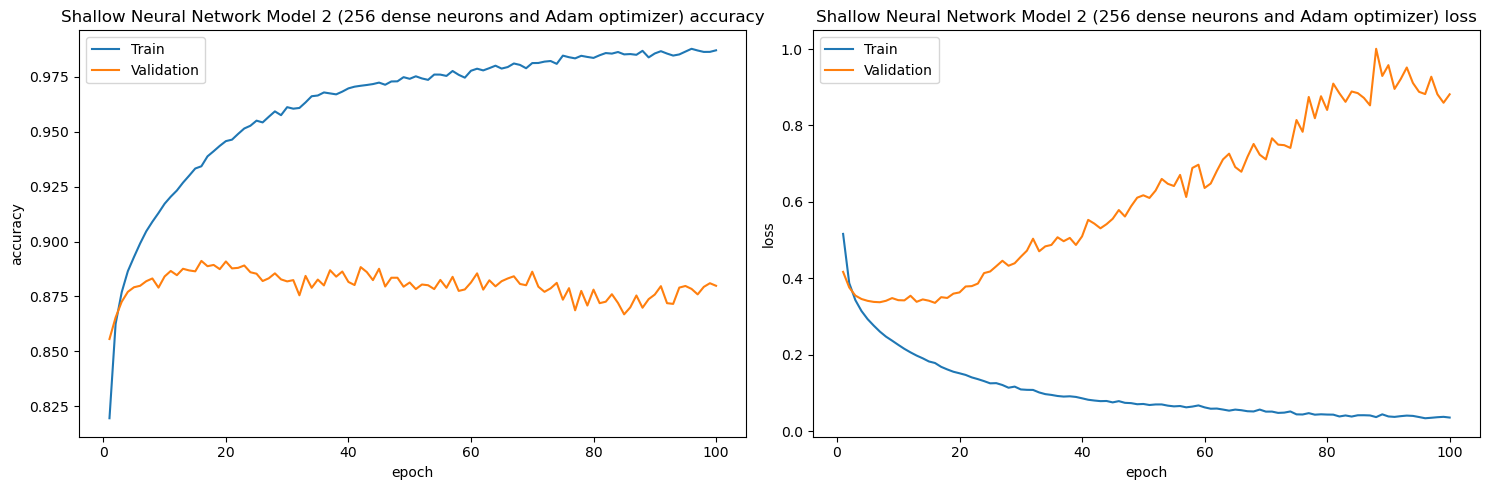

In [47]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn2_history, "Shallow Neural Network Model 2 (256 dense neurons and Adam optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9881.
  - Validation Accuracy of 0.8733. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.0324
  - Validation Loss: 0.9158

313/313 - 0s - 828us/step - accuracy: 0.8725 - loss: 0.9626

Test accuracy for Shallow Neural Network 2: 0.8725

Test loss for Shallow Neural Network 2: 0.9626

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 2 :
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1000
           1       0.98      0.98      0.98      1000
           2       0.80      0.74      0.77      1000
           3       0.90      0.88      0.89      1000
           4       0.79      0.79      0.79      1000
           5       0.97      0.96      0.96      1000
           6       0.61      0.77      0.68      1000
           7       0.93      0.96      0.95      1000
           8       0.98      0.95      0.97      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.87     10

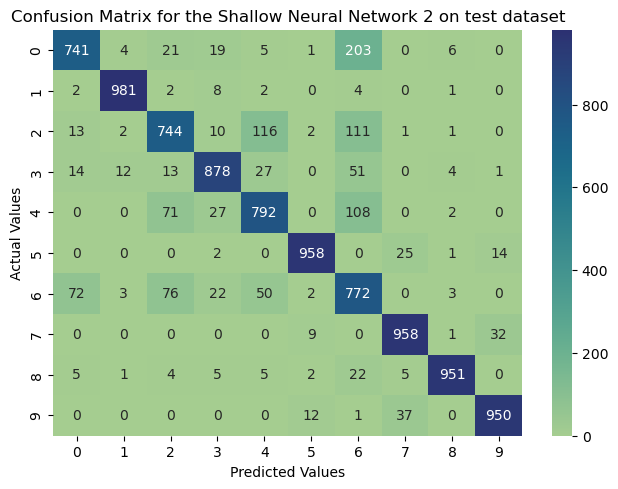

In [49]:
snn2_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model2, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 2")

### Shallow Neural Network Model 3

In this model, 
- I splitted the one dense layer of 256 neurons into the 2 dense layers with 128 neurons in each layer.
- Optimization function is also changed from Adam Optimizer to the SGD Optimizer. 

In [50]:
#Shallow Neural Network Model 3
shallow_nn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape= (28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
shallow_nn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn3_history = shallow_nn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5513 - loss: 1.4911 - val_accuracy: 0.7632 - val_loss: 0.7477
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7715 - loss: 0.7110 - val_accuracy: 0.8031 - val_loss: 0.6092
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8048 - loss: 0.5941 - val_accuracy: 0.8173 - val_loss: 0.5497
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8183 - loss: 0.5389 - val_accuracy: 0.8242 - val_loss: 0.5159
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8279 - loss: 0.5062 - val_accuracy: 0.8311 - val_loss: 0.4938
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8352 - loss: 0.4843 - val_accuracy: 0.8364 - val_loss: 0.4780
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8401 - loss: 0.4680 - val_accuracy: 0.8401 - val_loss: 0.4659
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8437 - loss: 0.4552 - val_accu

In [54]:
shallow_nn_model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,148 (918.55 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

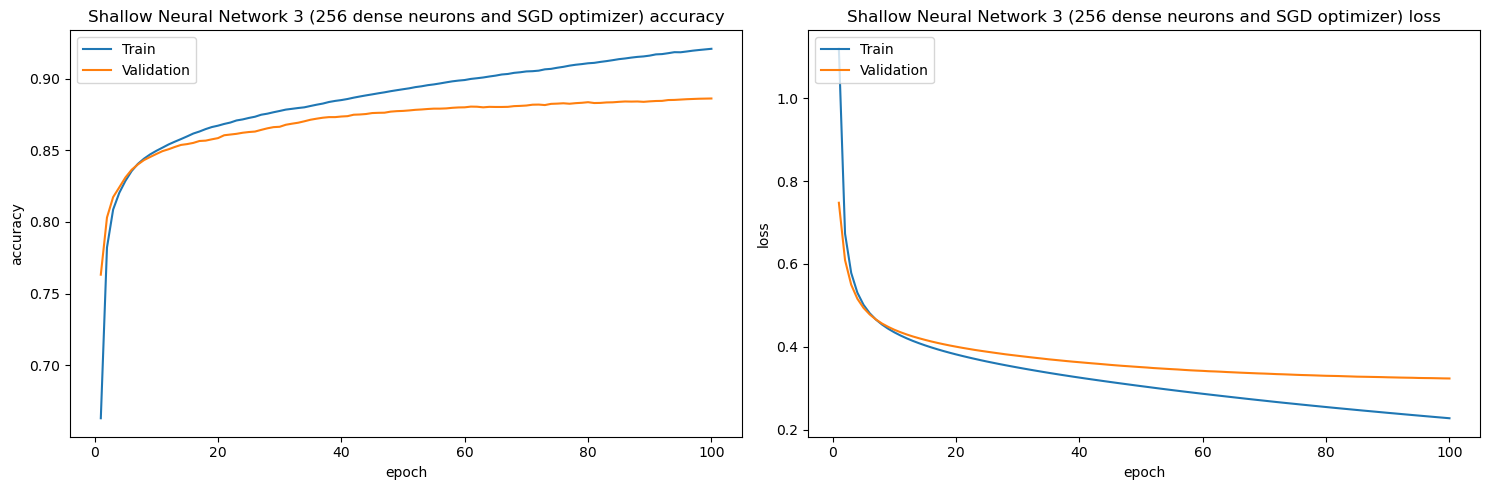

In [55]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn3_history, "Shallow Neural Network 3 (256 dense neurons and SGD optimizer)")

Above plot shows the change in accuracy and loss of both training data and validation data over the epoches. 

- **Accuracy**
  - Training Accuracy: 0.9136.
  - Validation Accuracy of 0.8845. 
  - Overfitting 

- **Categorical Cross EntropyLoss**
  - Training Loss: 0.2454
  - Validation Loss: 0.3316

313/313 - 0s - 916us/step - accuracy: 0.8779 - loss: 0.3500

Test accuracy for Shallow Neural Network 3: 0.8779

Test loss for Shallow Neural Network 3: 0.3500

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow Neural Network 3 :
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.78      0.82      0.80      1000
           3       0.87      0.87      0.87      1000
           4       0.82      0.79      0.80      1000
           5       0.96      0.95      0.96      1000
           6       0.68      0.73      0.71      1000
           7       0.91      0.96      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.88     10

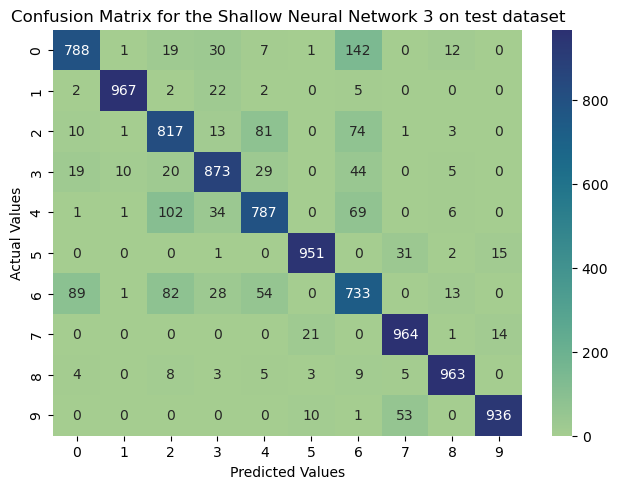

In [57]:
snn3_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model3, test_images, test_labels, test_labels_onehot, "Shallow Neural Network 3")

### Shallow Neural Network with Data Augumentation, Droplet and Batch Normalization

In [283]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_onehot, test_size= 0.2, random_state= 42)

In [284]:
train_images_with_channel = tf.expand_dims(X_train, axis= -1)
# test_images_with_channel = tf.expand_dims(test_images, axis= -1)

In [285]:
data_augumentation = tf.keras.Sequential([
    #Data Augumentation 
    tf.keras.layers.RandomFlip(mode= "horizontal", seed= seed_value, ),
    tf.keras.layers.RandomRotation(factor=0.2, seed= seed_value),
])

# # data_augumentation()
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_with_channel, y_train))

# Shuffle, augment, batch, and prefetch the training data
batch_size = 64
train_dataset1 = (
    train_dataset
    .shuffle(buffer_size=1000)  # Shuffle the data
    .map(lambda x, y: (data_augumentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .batch(batch_size)  # Batch the data
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
)


In [286]:
#Shallow Neural Network Model 4

shallow_nn_model4 = tf.keras.Sequential([
    #Input
    tf.keras.layers.Input(shape= (28, 28)),

    #Data Augmentation
    # data_augumentation,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),


    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn4_history = shallow_nn_model4.fit(train_dataset1, epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.2261 - loss: 2.1355 - val_accuracy: 0.5454 - val_loss: 1.5231
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5064 - loss: 1.5406 - val_accuracy: 0.6271 - val_loss: 1.1936
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6020 - loss: 1.2316 - val_accuracy: 0.6617 - val_loss: 1.0515
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6467 - loss: 1.0831 - val_accuracy: 0.6793 - val_loss: 0.9701
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6622 - loss: 1.0028 - val_accuracy: 0.6882 - val_loss: 0.9264
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6776 - loss: 0.9468 - val_accuracy: 0.6967 - val_loss: 0.8880
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6877 - loss: 0.9102 - val_accuracy: 0.7085 - val_loss: 0.8548
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6964 - loss: 0.8766 - val_accu

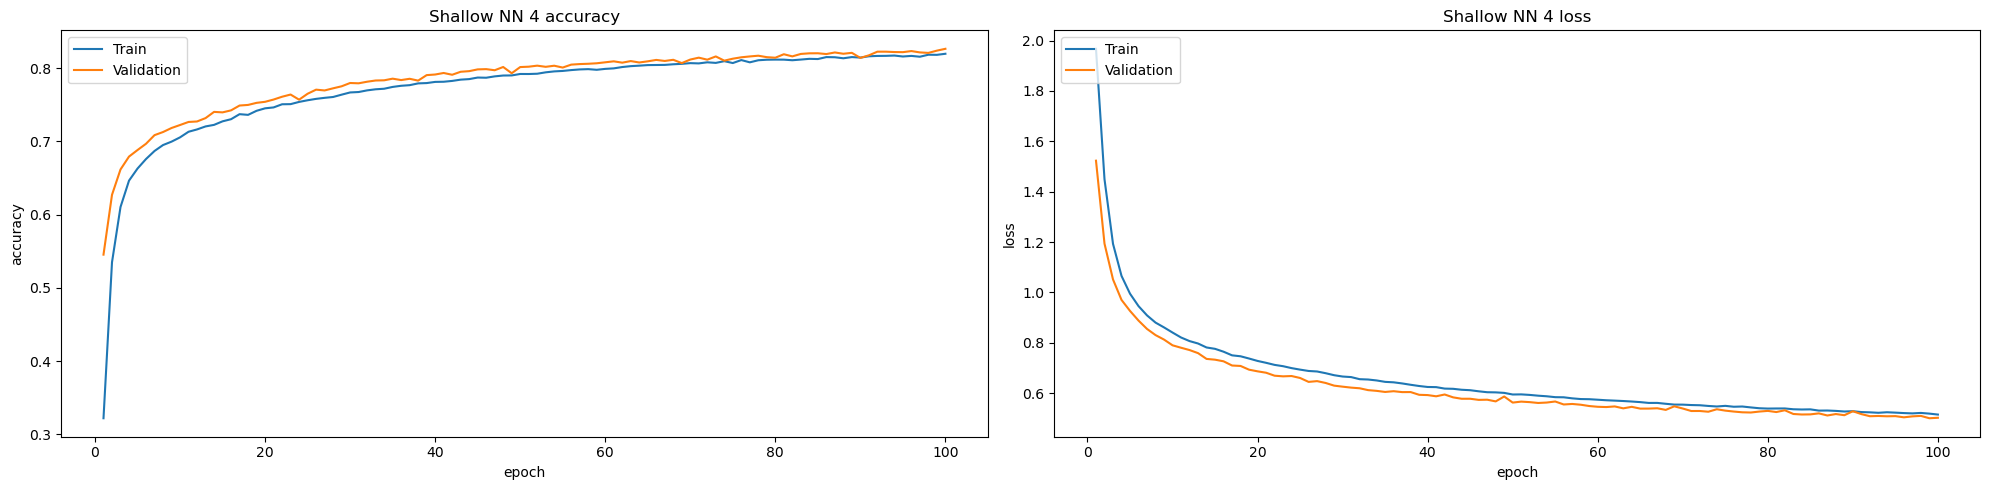

In [287]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn4_history, "Shallow NN 4")

In [288]:
#Shallow Neural Network Model 4

shallow_nn_model5 = tf.keras.Sequential([
    #Input
    tf.keras.layers.Input(shape= (28, 28)),

    #Data Augmentation
    # data_augumentation,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),

    #dropout layer
    tf.keras.layers.Dropout(rate= 0.1),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn5_history = shallow_nn_model5.fit(train_dataset1, epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5354 - loss: 1.2571 - val_accuracy: 0.7179 - val_loss: 0.7702
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6882 - loss: 0.8550 - val_accuracy: 0.7498 - val_loss: 0.6946
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7095 - loss: 0.8016 - val_accuracy: 0.7648 - val_loss: 0.6608
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7230 - loss: 0.7566 - val_accuracy: 0.7821 - val_loss: 0.6049
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7381 - loss: 0.7269 - val_accuracy: 0.7803 - val_loss: 0.6104
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7365 - loss: 0.7284 - val_accuracy: 0.7788 - val_loss: 0.6200
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7489 - loss: 0.7031 - val_accuracy: 0.7815 - val_loss: 0.6009
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7487 - loss: 0.6967 - val_accu

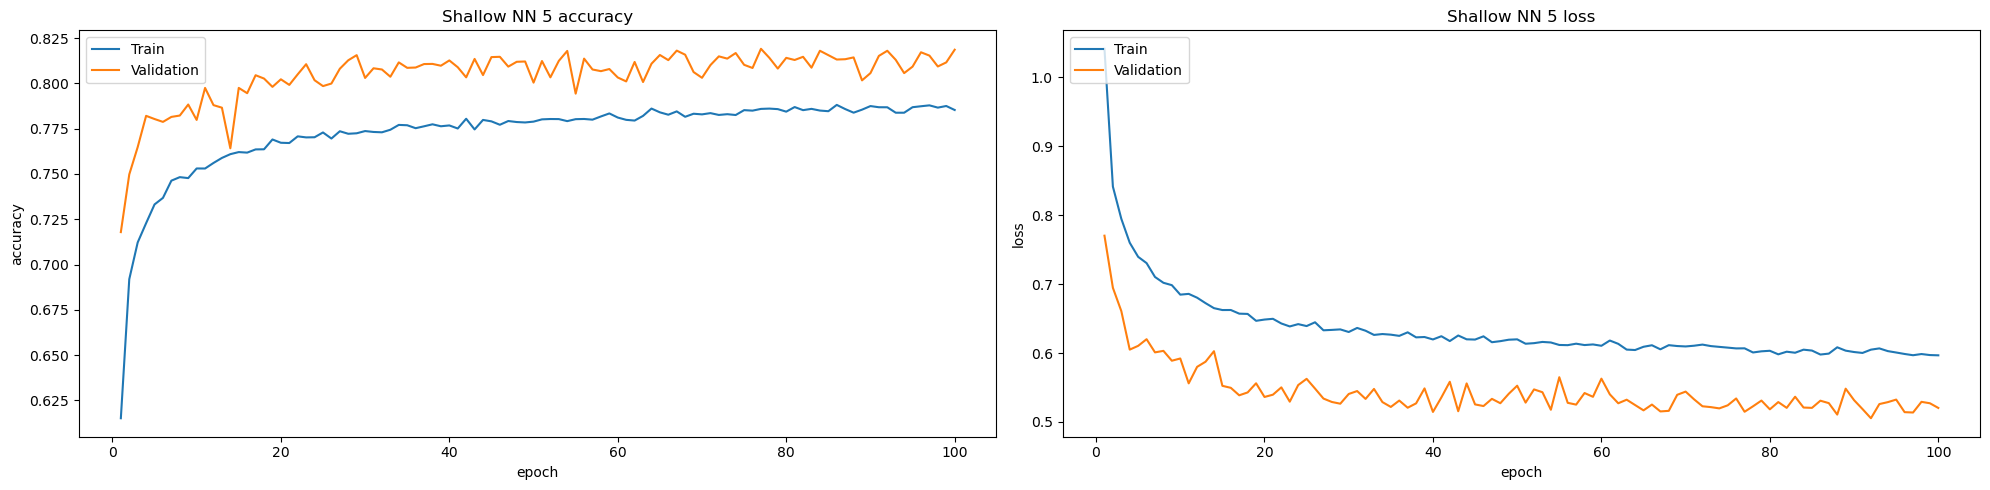

In [289]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn5_history, "Shallow NN 5")

313/313 - 1s - 5ms/step - accuracy: 0.8078 - loss: 0.5432

Test accuracy for Shallow 5: 0.8078

Test loss for Shallow 5: 0.5432

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
first 10 predicted outputs: [7 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow 5 :
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1000
           1       0.98      0.92      0.95      1000
           2       0.71      0.68      0.70      1000
           3       0.76      0.84      0.80      1000
           4       0.66      0.74      0.70      1000
           5       0.90      0.89      0.89      1000
           6       0.57      0.50      0.53      1000
           7       0.84      0.95      0.89      1000
           8       0.93      0.93      0.93      1000
           9       0.95      0.88      0.92      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81  

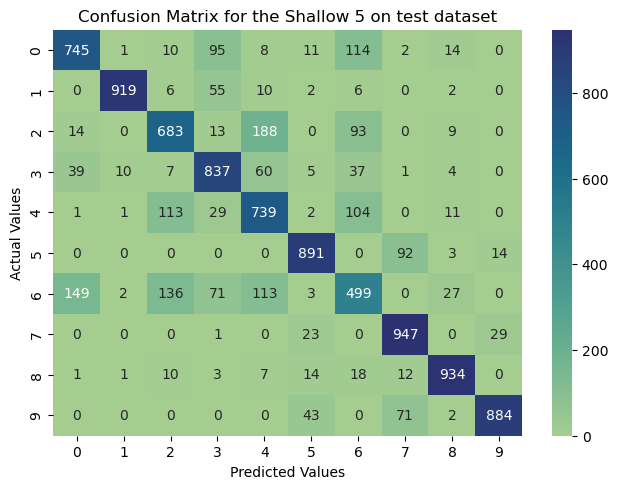

In [290]:
snn5_prediction_result_softmax = EvaluateNeuralNetworkModel(shallow_nn_model5, test_images, test_labels, test_labels_onehot, "Shallow 5")

In [291]:
#Shallow Neural Network Model 6

shallow_nn_model6 = tf.keras.Sequential([
    #Input
    tf.keras.layers.Input(shape= (28, 28)),

    #Data Augmentation
    # data_augumentation,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.BatchNormalization(),


    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

shallow_nn_model6.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

shallow_nn6_history = shallow_nn_model6.fit(train_dataset1 , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3962 - loss: 1.7557 - val_accuracy: 0.6642 - val_loss: 1.0265
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6512 - loss: 1.0373 - val_accuracy: 0.6982 - val_loss: 0.8812
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6877 - loss: 0.9130 - val_accuracy: 0.7192 - val_loss: 0.8024
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7019 - loss: 0.8561 - val_accuracy: 0.7340 - val_loss: 0.7559
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7143 - loss: 0.8100 - val_accuracy: 0.7428 - val_loss: 0.7236
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7277 - loss: 0.7839 - val_accuracy: 0.7527 - val_loss: 0.6987
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7363 - loss: 0.7490 - val_accuracy: 0.7570 - val_loss: 0.6789
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7387 - loss: 0.7335 - val_accu

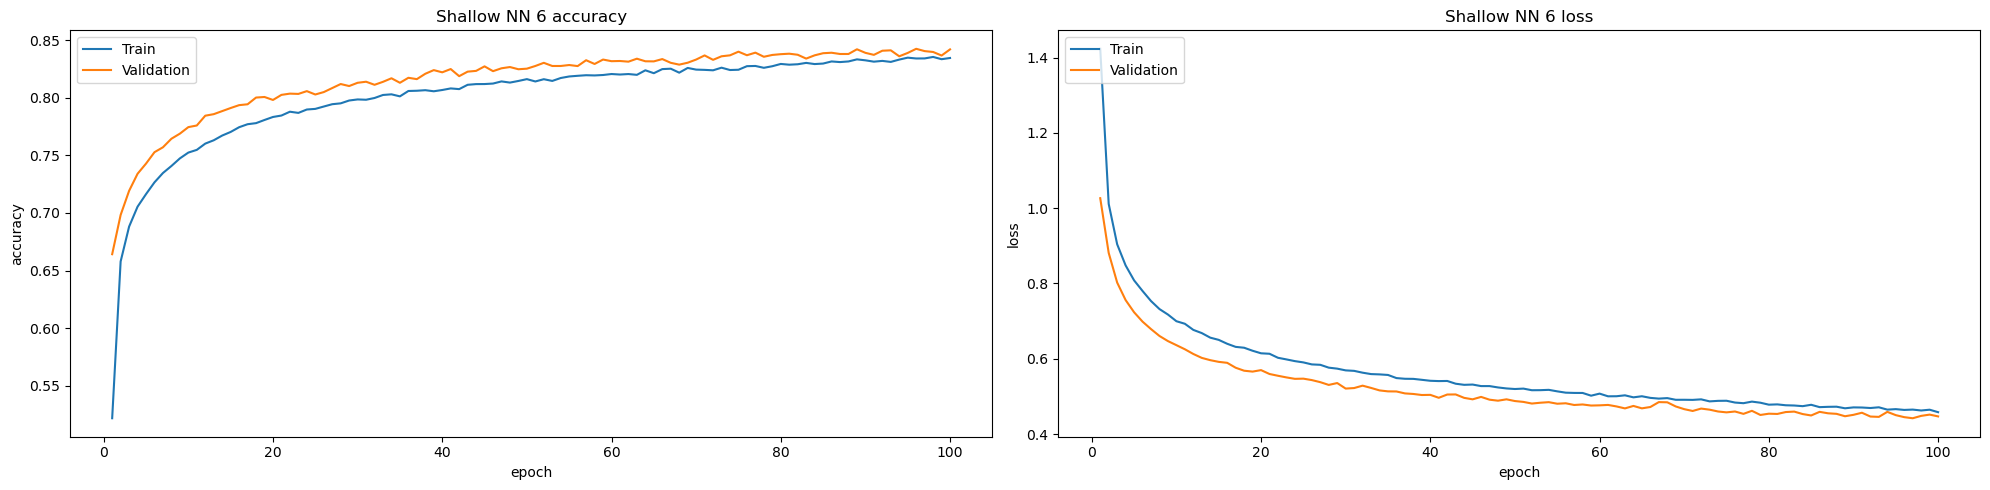

In [292]:
PlotTrainAndValidationAccuracyAndLoss(shallow_nn6_history, "Shallow NN 6")

313/313 - 1s - 5ms/step - accuracy: 0.8295 - loss: 0.4803

Test accuracy for Shallow NN 6: 0.8295

Test loss for Shallow NN 6: 0.4803

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Shallow NN 6 :
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1000
           1       0.98      0.94      0.96      1000
           2       0.72      0.69      0.71      1000
           3       0.83      0.84      0.84      1000
           4       0.72      0.76      0.74      1000
           5       0.92      0.92      0.92      1000
           6       0.59      0.65      0.62      1000
           7       0.91      0.89      0.90      1000
           8       0.92      0.94      0.93      1000
           9       0.90      0.94      0.92      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83   

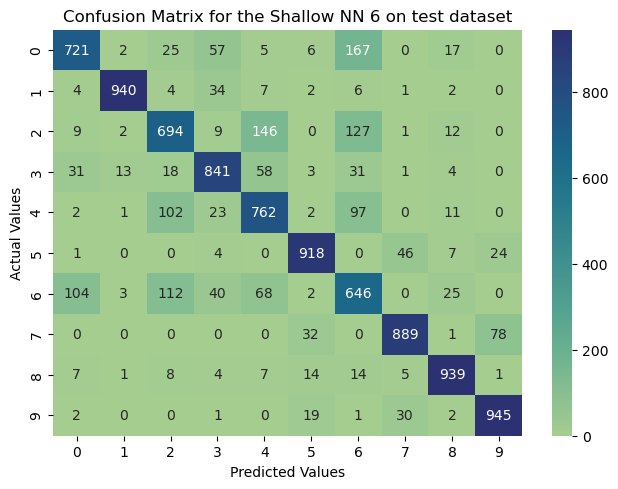

array([[3.8111461e-06, 1.4713910e-09, 3.3496548e-09, ..., 2.1157818e-02,
        2.5689349e-04, 9.7139996e-01],
       [1.4392010e-04, 1.0797091e-06, 9.8363519e-01, ..., 3.6245332e-08,
        2.2803826e-07, 2.5542459e-09],
       [1.1502958e-06, 9.9999619e-01, 1.6661117e-07, ..., 6.1729910e-10,
        3.6583410e-07, 7.1816324e-08],
       ...,
       [3.3480324e-02, 7.6274750e-07, 7.1598035e-05, ..., 2.1919491e-06,
        9.6497059e-01, 7.3106258e-07],
       [3.6791276e-05, 9.9705672e-01, 1.3891075e-05, ..., 6.2818144e-06,
        2.1756368e-05, 2.1473244e-05],
       [2.1809402e-03, 3.0012702e-06, 8.2632680e-05, ..., 3.0774221e-01,
        3.2199081e-02, 1.4652044e-03]], dtype=float32)

In [293]:
EvaluateNeuralNetworkModel(shallow_nn_model6, test_images, test_labels,test_labels_onehot, "Shallow NN 6")

Loss for the Shallow neural network committee on test dataset: 0.3466
Accuracy for the Shallow neural network committee on test dataset: 0.8846
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.82      0.81      1000
           3       0.89      0.90      0.90      1000
           4       0.86      0.77      0.81      1000
           5       0.97      0.96      0.97      1000
           6       0.63      0.78      0.70      1000
           7       0.93      0.97      0.95      1000
           8       0.99      0.96      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg  

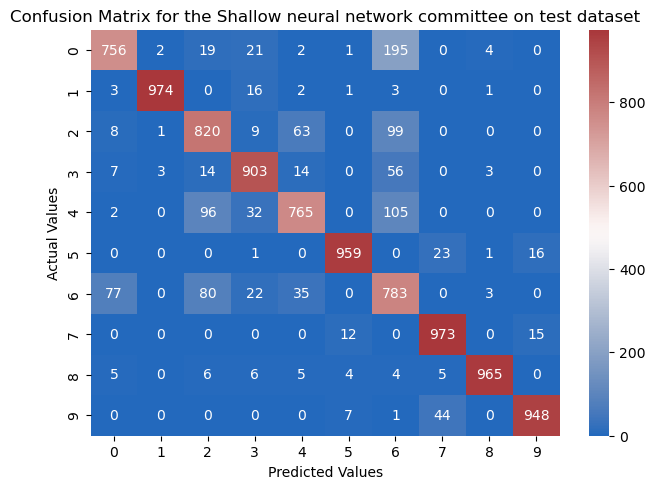

In [294]:
ModelCommitteeAnalysis([
    snn1_prediction_result_softmax, 
    snn2_prediction_result_softmax, 
    snn3_prediction_result_softmax], 
    test_labels, "Shallow")

### Basic Convolutional Neural Network 1

In [295]:
simple_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 128, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn1_history = simple_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 32)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8176 - loss: 0.5238 - val_accuracy: 0.8804 - val_loss: 0.3349
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8878 - loss: 0.3098 - val_accuracy: 0.8759 - val_loss: 0.3757
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9022 - loss: 0.2684 - val_accuracy: 0.8831 - val_loss: 0.3667
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9146 - loss: 0.2357 - val_accuracy: 0.8807 - val_loss: 0.3971
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9236 - loss: 0.2078 - val_accuracy: 0.8833 - val_loss: 0.4460
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9276 - loss: 0.2003 - val_accuracy: 0.8825 - val_loss: 0.4606
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9302 - loss: 0.1933 - val_accuracy: 0.8827 - val_loss: 0.5395
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9393 - loss: 0.1663 - val

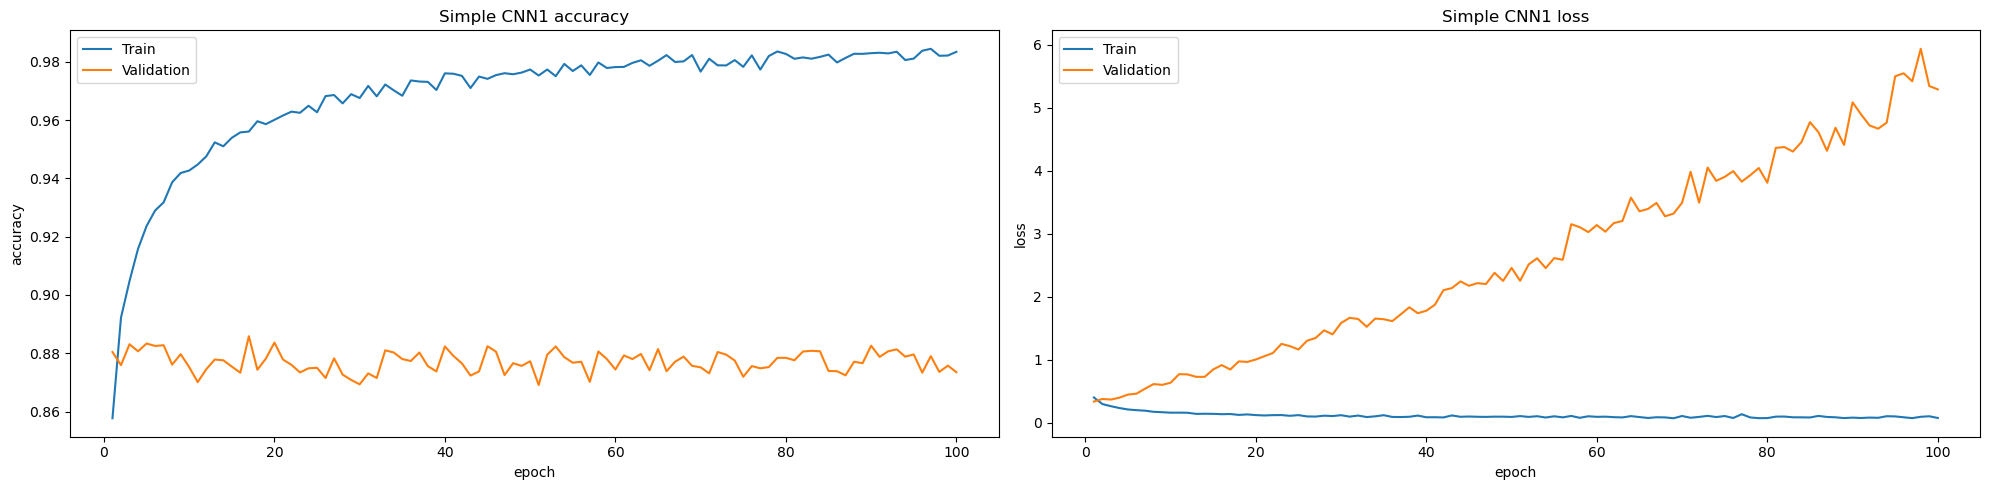

In [296]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn1_history, "Simple CNN1")

/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 - 2s - 7ms/step - accuracy: 0.8724 - loss: 5.1743

Test accuracy for Simple CNN 1: 0.8724

Test loss for Simple CNN 1: 5.1743

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 1 :
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.72      0.80      0.76      1000
           3       0.91      0.85      0.88      1000
           4       0.78      0.74      0.76      1000
           5       0.99      0.97      0.98      1000
           6       0.66      0.67      0.66      1000
           7       0.95      0.96      0.95      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87   

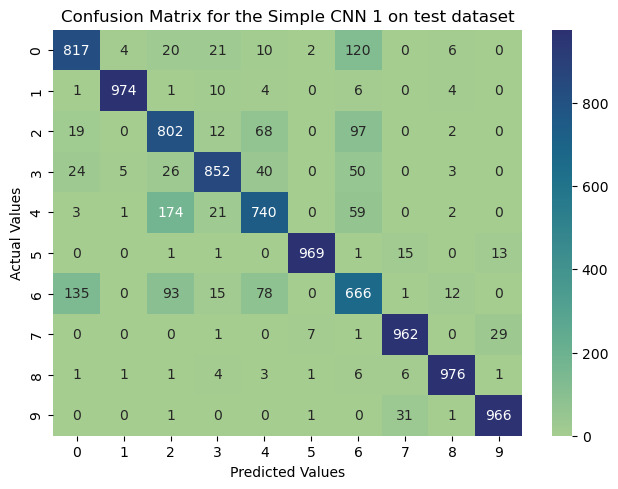

In [297]:
simple_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model1, test_images, test_labels, test_labels_onehot, "Simple CNN 1")

In [298]:
simple_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 64, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "relu"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn2_history = simple_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7776 - loss: 0.6191 - val_accuracy: 0.8804 - val_loss: 0.3451
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8842 - loss: 0.3295 - val_accuracy: 0.8917 - val_loss: 0.3019
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8976 - loss: 0.2819 - val_accuracy: 0.8972 - val_loss: 0.2812
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9088 - loss: 0.2485 - val_accuracy: 0.9035 - val_loss: 0.2660
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9200 - loss: 0.2203 - val_accuracy: 0.9062 - val_loss: 0.2593
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9292 - loss: 0.1962 - val_accuracy: 0.9051 - val_loss: 0.2629
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9381 - loss: 0.1735 - val_accuracy: 0.9068 - val_loss: 0.2642
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9465 - loss: 0.1533 - val_accuracy: 0.9059

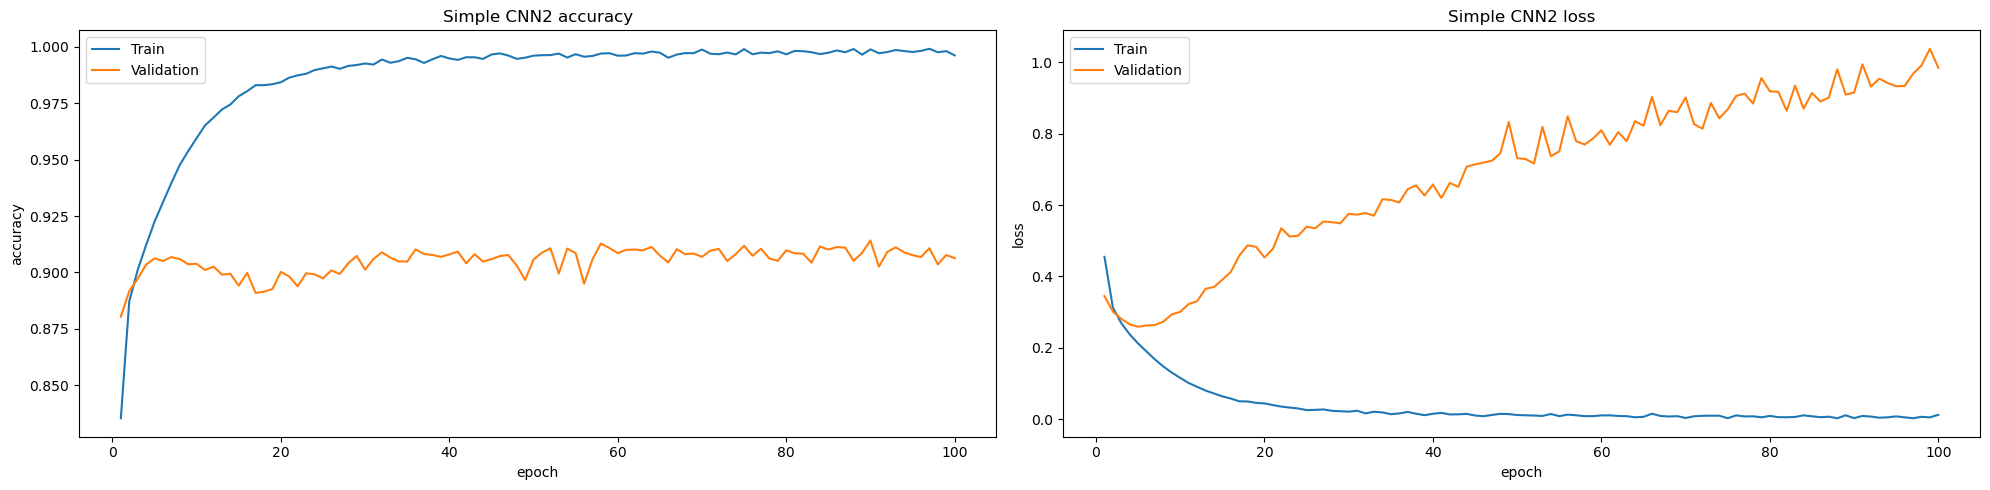

In [299]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn2_history, "Simple CNN2")

313/313 - 1s - 2ms/step - accuracy: 0.9045 - loss: 1.0478

Test accuracy for Simple CNN 2: 0.9045

Test loss for Simple CNN 2: 1.0478

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 2 :
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.88      0.82      0.85      1000
           3       0.91      0.90      0.90      1000
           4       0.81      0.91      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.75      0.71      0.73      1000
           7       0.95      0.96      0.96      1000
           8       0.98      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90   

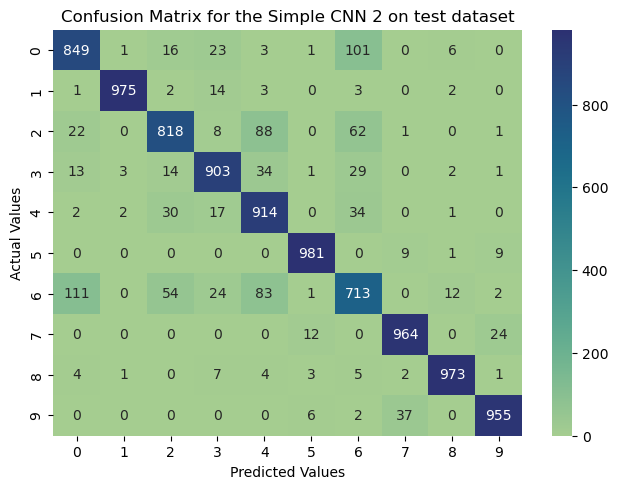

In [300]:
simple_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model2, test_images, test_labels, test_labels_onehot, "Simple CNN 2")

In [301]:
simple_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

simple_cnn3_history = simple_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5638 - loss: 1.4724 - val_accuracy: 0.7792 - val_loss: 0.6436
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7856 - loss: 0.6195 - val_accuracy: 0.8064 - val_loss: 0.5470
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8086 - loss: 0.5376 - val_accuracy: 0.8174 - val_loss: 0.5073
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8223 - loss: 0.4986 - val_accuracy: 0.8251 - val_loss: 0.4831
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8314 - loss: 0.4736 - val_accuracy: 0.8331 - val_loss: 0.4657
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8378 - loss: 0.4550 - val_accuracy: 0.8386 - val_loss: 0.4520
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8439 - loss: 0.4402 - val_accuracy: 0.8425 - val_loss: 0.4407
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8488 - loss: 0.4279 - val_accuracy: 0.8461

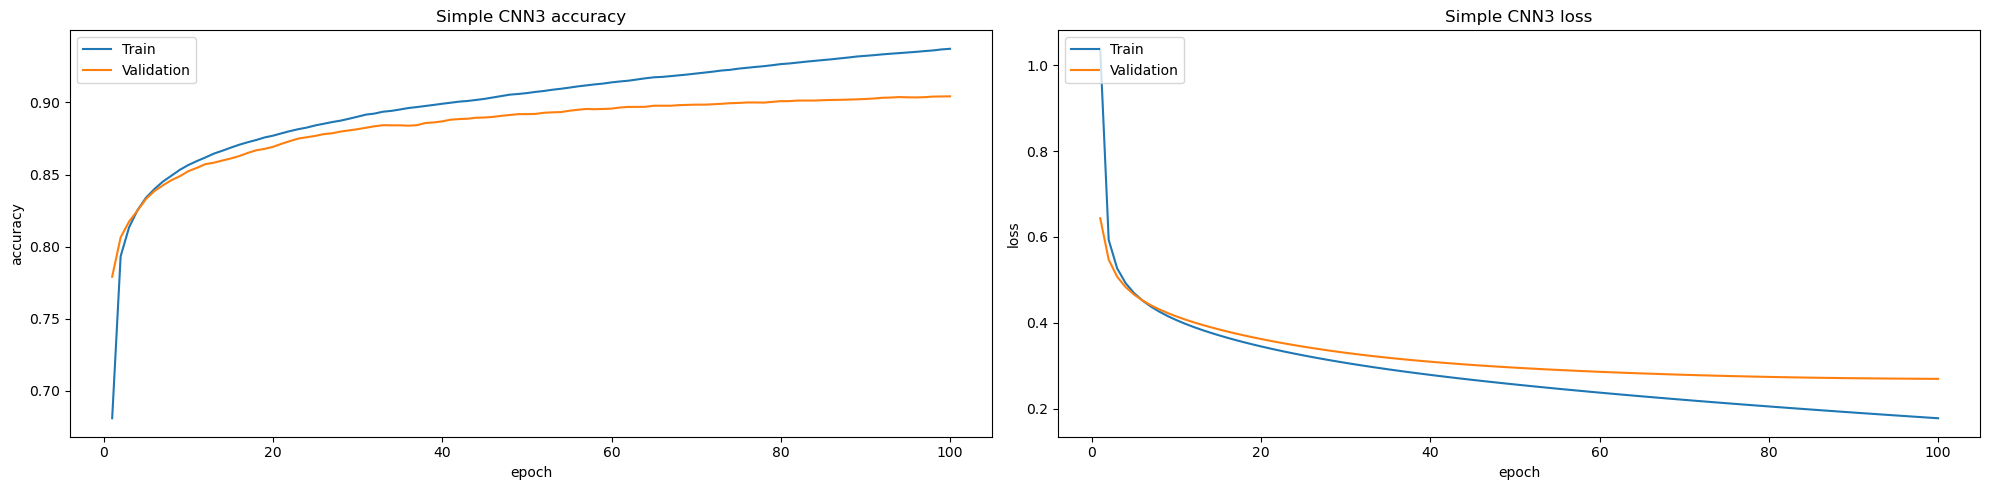

In [302]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn3_history, "Simple CNN3")

313/313 - 2s - 5ms/step - accuracy: 0.8973 - loss: 0.2827

Test accuracy for Simple CNN 3: 0.8973

Test loss for Simple CNN 3: 0.2827

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 3 :
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.88      0.84      1000
           3       0.89      0.91      0.90      1000
           4       0.88      0.78      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.70      0.78      0.74      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90   

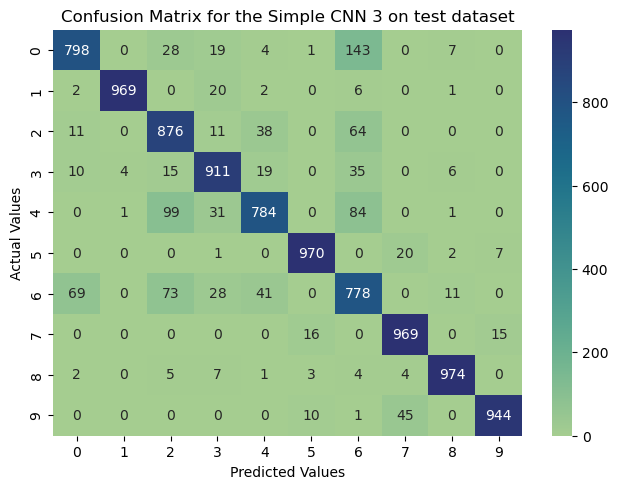

In [303]:
simple_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(simple_cnn_model3, test_images, test_labels, test_labels_onehot, "Simple CNN 3")

### Simple CNN Model with Data Augmentation, Droplet and Batch Normalization

In [304]:
#Shallow Neural Network Model 6

simple_cnn_model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

simple_cnn_model4.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

simple_cnn4_history = simple_cnn_model4.fit(train_dataset1 , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5631 - loss: 1.2841 - val_accuracy: 0.7514 - val_loss: 0.7593
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7408 - loss: 0.7812 - val_accuracy: 0.7806 - val_loss: 0.6452
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7698 - loss: 0.6874 - val_accuracy: 0.7878 - val_loss: 0.6122
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7859 - loss: 0.6304 - val_accuracy: 0.7972 - val_loss: 0.5797
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8006 - loss: 0.5945 - val_accuracy: 0.8202 - val_loss: 0.5256
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8038 - loss: 0.5735 - val_accuracy: 0.8183 - val_loss: 0.5211
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8160 - loss: 0.5439 - val_accuracy: 0.8230 - val_loss: 0.5081
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8220 - loss: 0.5262 

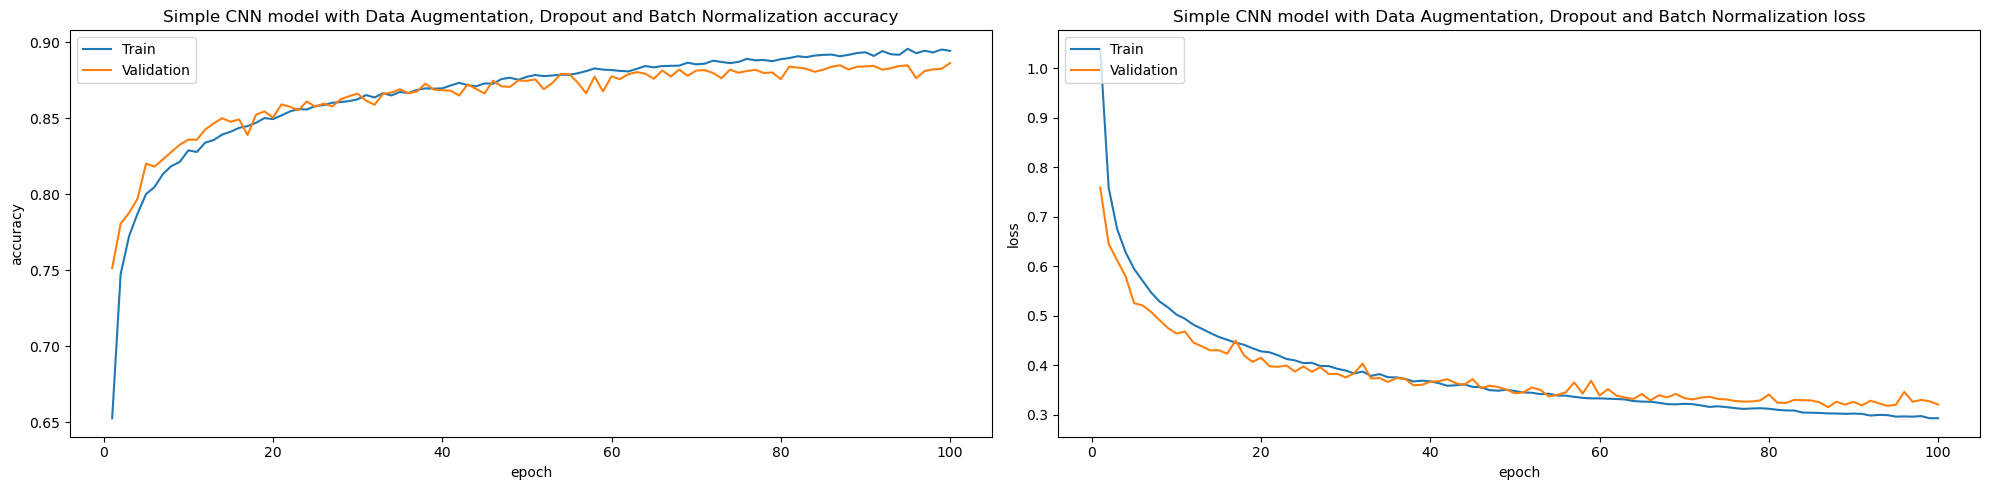

In [305]:
PlotTrainAndValidationAccuracyAndLoss(simple_cnn4_history, "Simple CNN model with Data Augmentation, Dropout and Batch Normalization")

313/313 - 1s - 5ms/step - accuracy: 0.8787 - loss: 0.3525

Test accuracy for Simple CNN 6: 0.8787

Test loss for Simple CNN 6: 0.3525

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Simple CNN 6 :
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.83      0.81      1000
           3       0.87      0.89      0.88      1000
           4       0.87      0.73      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.65      0.75      0.70      1000
           7       0.92      0.97      0.94      1000
           8       0.94      0.96      0.95      1000
           9       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88   

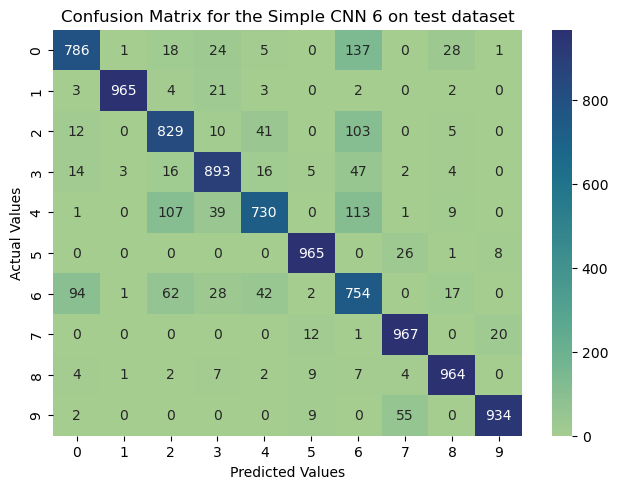

array([[6.4736523e-06, 8.2862389e-06, 3.0593768e-07, ..., 1.8771669e-02,
        3.4883962e-04, 9.3015164e-01],
       [2.0443997e-04, 3.5529456e-07, 9.9926621e-01, ..., 2.9502930e-06,
        2.8892572e-07, 4.9709030e-08],
       [2.8818738e-05, 9.9961120e-01, 1.6619018e-05, ..., 2.1899712e-07,
        3.7296406e-06, 5.8886367e-06],
       ...,
       [4.4615348e-03, 6.6374164e-06, 2.2945278e-04, ..., 1.1274270e-05,
        9.9424016e-01, 5.6765765e-07],
       [1.7967351e-06, 9.9973541e-01, 8.3941835e-08, ..., 9.8207693e-06,
        7.4953795e-07, 3.3976896e-05],
       [7.3741534e-04, 1.7318067e-05, 1.9558607e-05, ..., 6.0376924e-01,
        1.9857595e-02, 3.5515106e-03]], dtype=float32)

In [306]:
EvaluateNeuralNetworkModel(simple_cnn_model4, test_images, test_labels, test_labels_onehot, "Simple CNN 6")

### Simple CNN committee

Loss for the Simple Convolution neural network committee on test dataset: 0.2591
Accuracy for the Simple Convolution neural network committee on test dataset: 0.9149
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1000
           1       1.00      0.97      0.99      1000
           2       0.84      0.87      0.86      1000
           3       0.91      0.92      0.92      1000
           4       0.86      0.86      0.86      1000
           5       0.99      0.98      0.98      1000
           6       0.77      0.75      0.76      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91   

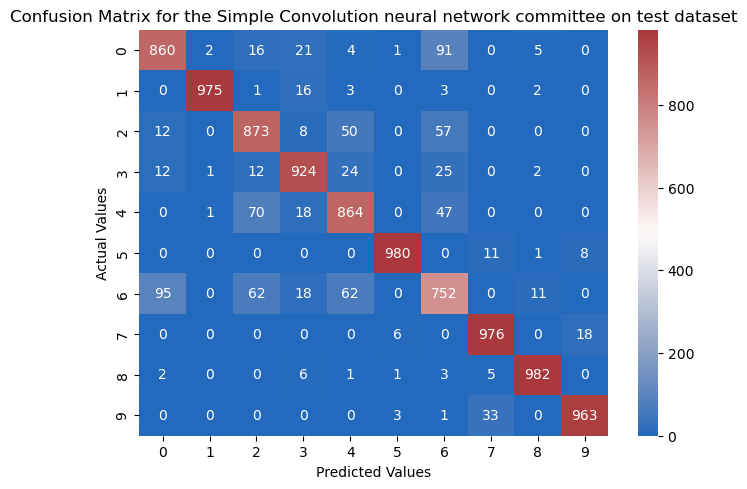

In [307]:
ModelCommitteeAnalysis(
    [simple_cnn1_prediction_result_softmax, 
     simple_cnn2_prediction_result_softmax, 
     simple_cnn3_prediction_result_softmax], 
    test_labels, "Simple Convolution")

## Deep Convolution Neural Network

### Deep CNN 1

In [308]:
deep_cnn_model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn1_history = deep_cnn_model1.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7713 - loss: 0.6186 - val_accuracy: 0.8804 - val_loss: 0.3322
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8838 - loss: 0.3241 - val_accuracy: 0.8912 - val_loss: 0.3016
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9018 - loss: 0.2726 - val_accuracy: 0.8998 - val_loss: 0.2774
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9131 - loss: 0.2350 - val_accuracy: 0.9009 - val_loss: 0.2767
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9260 - loss: 0.2034 - val_accuracy: 0.9027 - val_loss: 0.2816
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9357 - loss: 0.1737 - val_accuracy: 0.9078 - val_loss: 0.2851
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9457 - loss: 0.1476 - val_accuracy: 0.9028 - val_loss: 0.3071
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9554 - loss: 0.1244 - val_accuracy: 0.8982

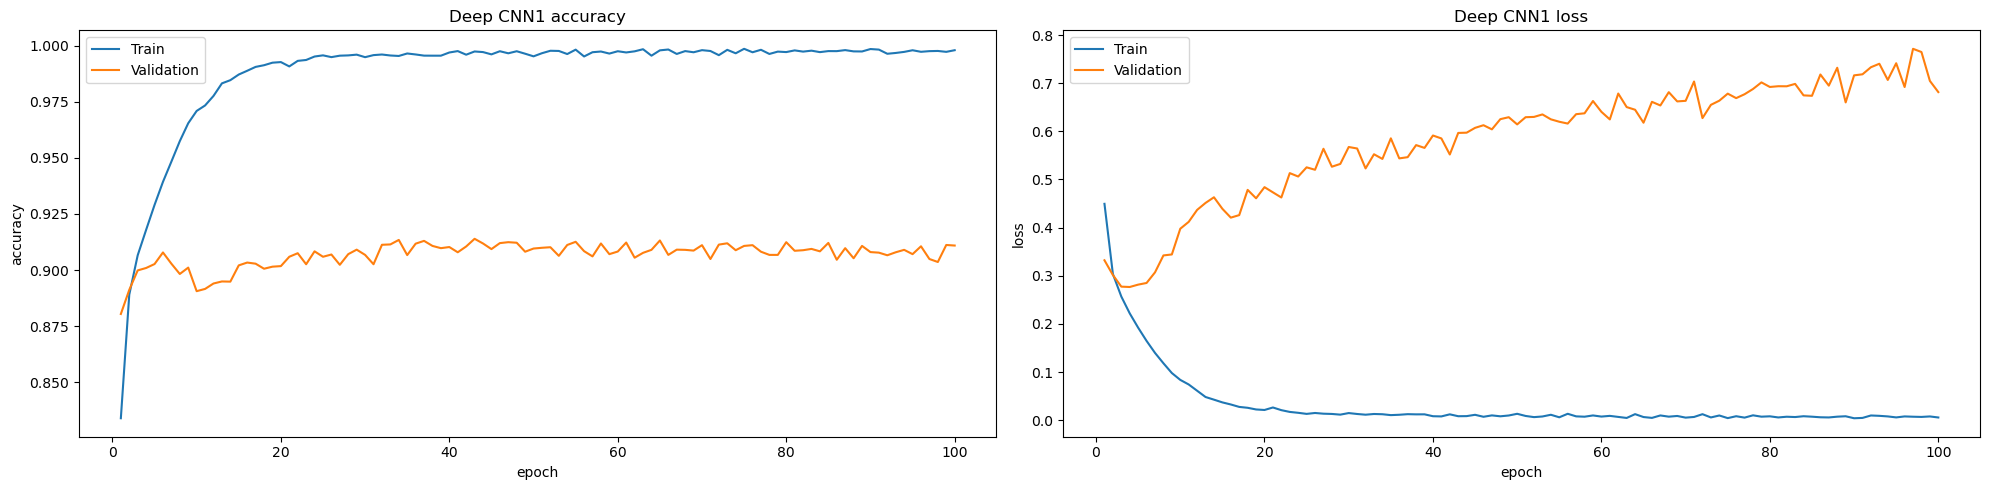

In [309]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn1_history, "Deep CNN1")

313/313 - 1s - 4ms/step - accuracy: 0.9100 - loss: 0.7060

Test accuracy for Deep CNN 1: 0.9100

Test loss for Deep CNN 1: 0.7060

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 1 :
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.88      0.87      1000
           3       0.92      0.90      0.91      1000
           4       0.86      0.86      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.76      0.74      0.75      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.9

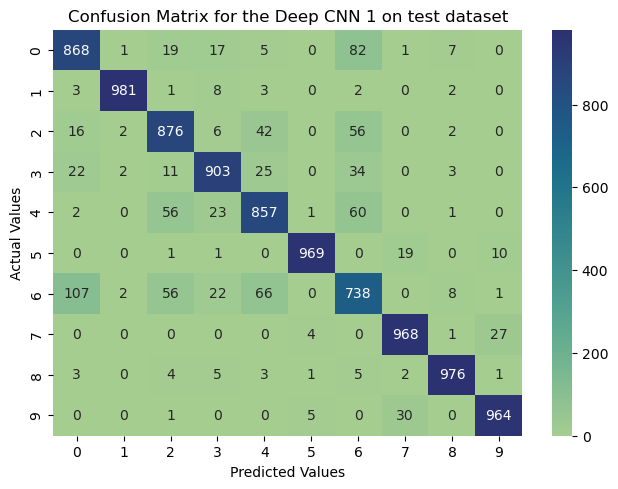

In [310]:
deep_cnn1_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model1, test_images, test_labels, test_labels_onehot, "Deep CNN 1")

### Deep CNN Model 2

In [311]:
deep_cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn2_history = deep_cnn_model2.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6842 - loss: 0.8600 - val_accuracy: 0.8367 - val_loss: 0.4480
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8408 - loss: 0.4359 - val_accuracy: 0.8622 - val_loss: 0.3745
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8648 - loss: 0.3682 - val_accuracy: 0.8720 - val_loss: 0.3479
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8788 - loss: 0.3275 - val_accuracy: 0.8813 - val_loss: 0.3318
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8896 - loss: 0.2970 - val_accuracy: 0.8863 - val_loss: 0.3236
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8987 - loss: 0.2715 - val_accuracy: 0.8881 - val_loss: 0.3205
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9086 - loss: 0.2462 - val_accuracy: 0.8851 - val_loss: 0.3308
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9172 - loss: 0.2248 - val_accuracy: 0.8839

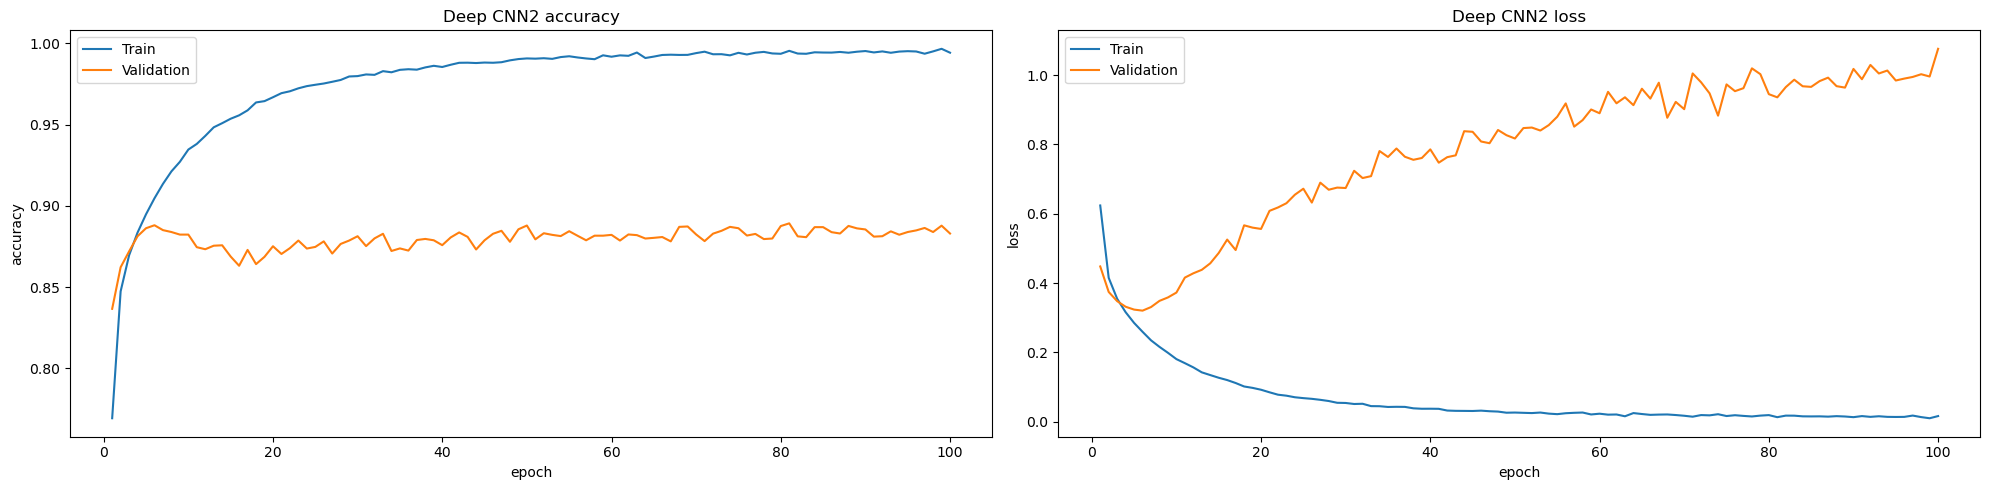

In [312]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn2_history, "Deep CNN2")

313/313 - 1s - 5ms/step - accuracy: 0.8781 - loss: 1.1318

Test accuracy for Deep CNN 2: 0.8781

Test loss for Deep CNN 2: 1.1318

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
first 10 predicted outputs: [9 2 1 1 4 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 2 :
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1000
           1       1.00      0.96      0.98      1000
           2       0.82      0.82      0.82      1000
           3       0.87      0.89      0.88      1000
           4       0.75      0.88      0.81      1000
           5       0.97      0.96      0.97      1000
           6       0.68      0.65      0.66      1000
           7       0.92      0.96      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.8

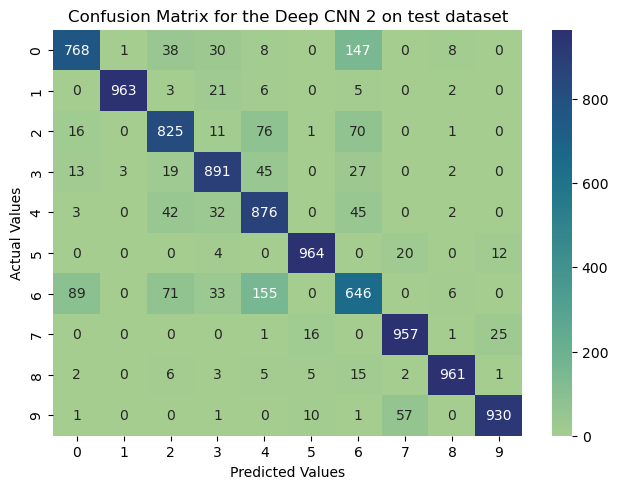

In [313]:
deep_cnn2_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model2, test_images, test_labels, test_labels_onehot, "Deep CNN 2")

### Deep CNN Model 3

In [314]:
deep_cnn_model3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

deep_cnn3_history = deep_cnn_model3.fit(train_images, train_labels_onehot, epochs=100, validation_split= 0.2, batch_size= 64)

Epoch 1/100


/home/buddha-thapa-magar/anaconda3/envs/ml/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3868 - loss: 1.8384 - val_accuracy: 0.7216 - val_loss: 0.8078
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7166 - loss: 0.7814 - val_accuracy: 0.7578 - val_loss: 0.6715
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7514 - loss: 0.6700 - val_accuracy: 0.7756 - val_loss: 0.6089
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7731 - loss: 0.6101 - val_accuracy: 0.7888 - val_loss: 0.5662
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7877 - loss: 0.5675 - val_accuracy: 0.8008 - val_loss: 0.5348
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7995 - loss: 0.5349 - val_accuracy: 0.8104 - val_loss: 0.5112
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8095 - loss: 0.5094 - val_accuracy: 0.8177 - val_loss: 0.4928
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8180 - loss: 0.4888 - val_accuracy: 0.8252

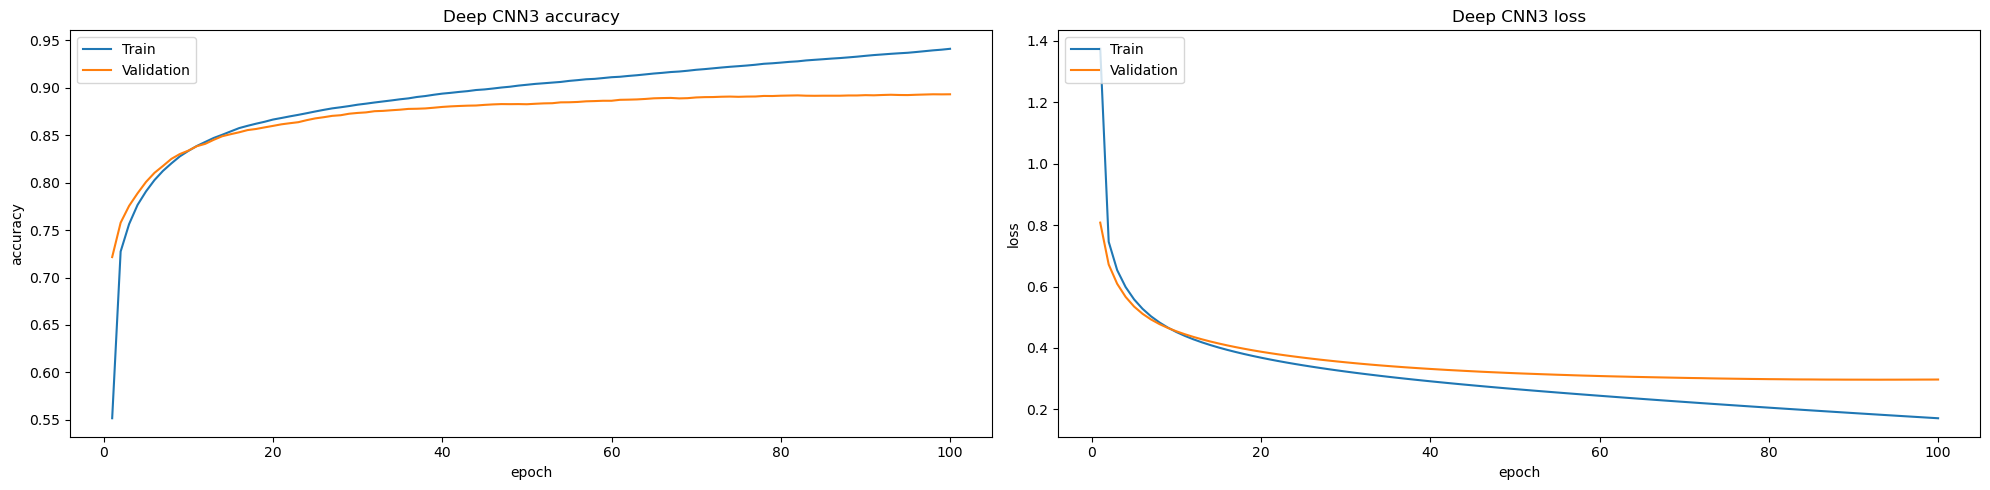

In [315]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn3_history, "Deep CNN3")

313/313 - 1s - 4ms/step - accuracy: 0.8905 - loss: 0.3066

Test accuracy for Deep CNN 3: 0.8905

Test loss for Deep CNN 3: 0.3066

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 3 :
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.85      0.83      1000
           3       0.88      0.92      0.90      1000
           4       0.84      0.79      0.82      1000
           5       0.98      0.97      0.97      1000
           6       0.68      0.72      0.70      1000
           7       0.93      0.97      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.98      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.8

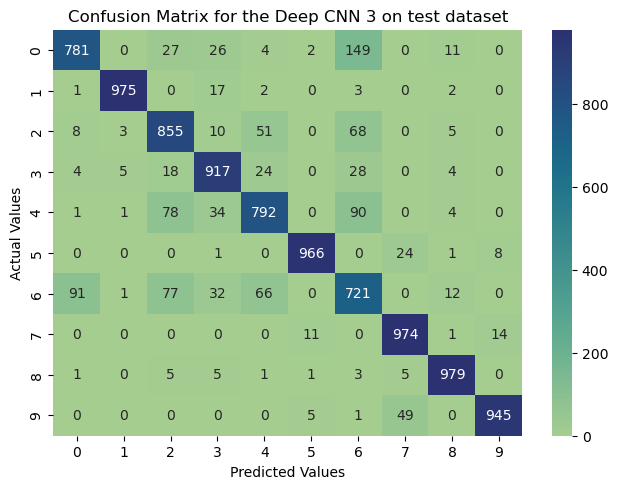

In [316]:
deep_cnn3_prediction_result_softmax = EvaluateNeuralNetworkModel(deep_cnn_model3, test_images, test_labels, test_labels_onehot, "Deep CNN 3")

### Deep CNN Model with Data Augmentation, Dropout, and Batch Normalization

In [ ]:
deep_cnn_model4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (28, 28, 1)),
    tf.keras.layers.Conv2D(filters= 32, kernel_size= (3, 3), activation= "relu"),
    tf.keras.layers.MaxPool2D(pool_size= (2, 2)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units= 256, activation= "tanh"),
    tf.keras.layers.Dense(10, activation='softmax')
])

deep_cnn_model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

deep_cnn4_history = deep_cnn_model4.fit(train_dataset1 , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.4861 - loss: 1.6256 - val_accuracy: 0.6167 - val_loss: 0.9966
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6346 - loss: 0.9921 - val_accuracy: 0.6292 - val_loss: 1.0117
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.6326 - loss: 1.0097 - val_accuracy: 0.6585 - val_loss: 0.9429
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6586 - loss: 0.9417 - val_accuracy: 0.6662 - val_loss: 0.9653
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6550 - loss: 0.9536 - val_accuracy: 0.6278 - val_loss: 1.0438
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6560 - loss: 0.9542 - val_accuracy: 0.6201 - val_loss: 0.9978
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6440 - loss: 0.9672 - val_accuracy: 0.6572 - val_loss: 0.9819
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6465 - loss: 0.9808 - 

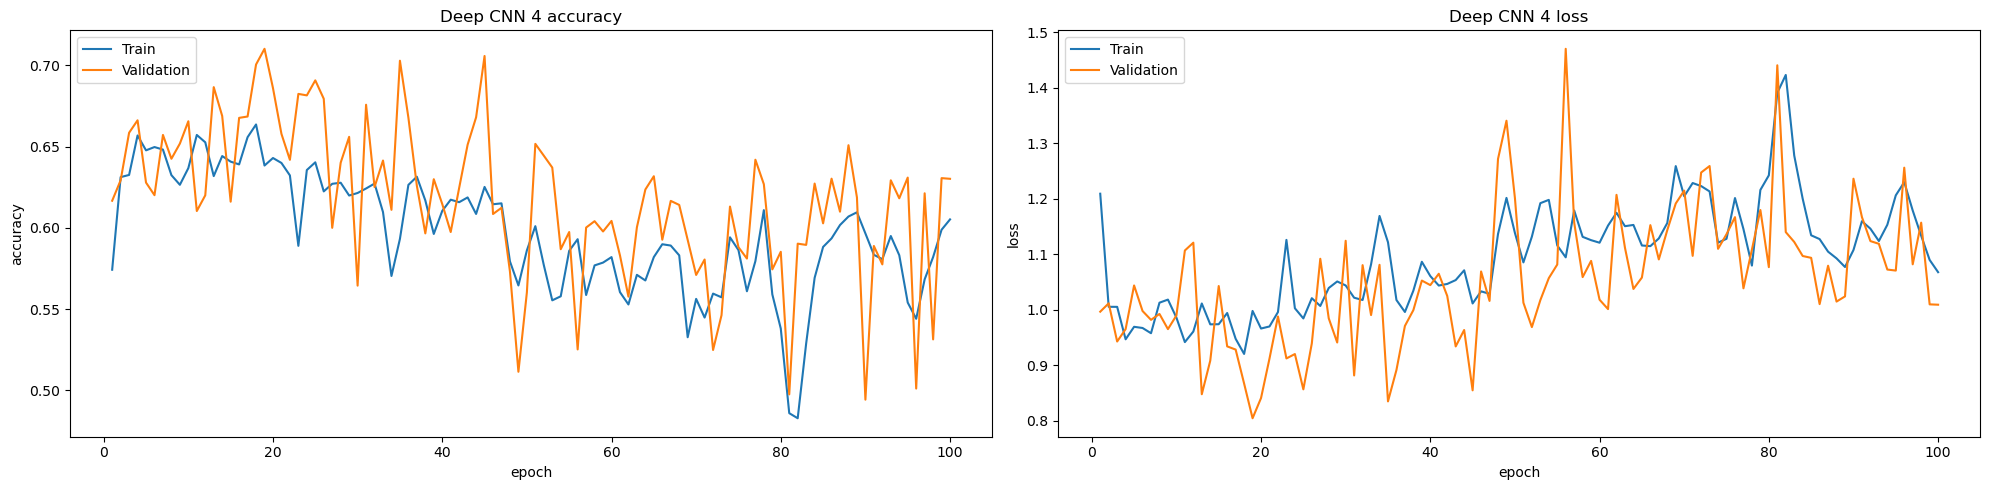

In [318]:
PlotTrainAndValidationAccuracyAndLoss(deep_cnn4_history, "Deep CNN 4")

313/313 - 2s - 5ms/step - accuracy: 0.6313 - loss: 1.0130

Test accuracy for Deep CNN 4: 0.6313

Test loss for Deep CNN 4: 1.0130

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
first 10 predicted outputs: [9 6 1 1 2 1 0 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for Deep CNN 4 :
              precision    recall  f1-score   support

           0       0.57      0.47      0.51      1000
           1       0.94      0.87      0.90      1000
           2       0.58      0.52      0.55      1000
           3       0.50      0.67      0.57      1000
           4       0.47      0.61      0.53      1000
           5       0.64      0.91      0.76      1000
           6       0.34      0.30      0.32      1000
           7       0.93      0.46      0.62      1000
           8       0.84      0.64      0.72      1000
           9       0.75      0.87      0.80      1000

    accuracy                           0.63     10000
   macro avg       0.66      0.63      0.6

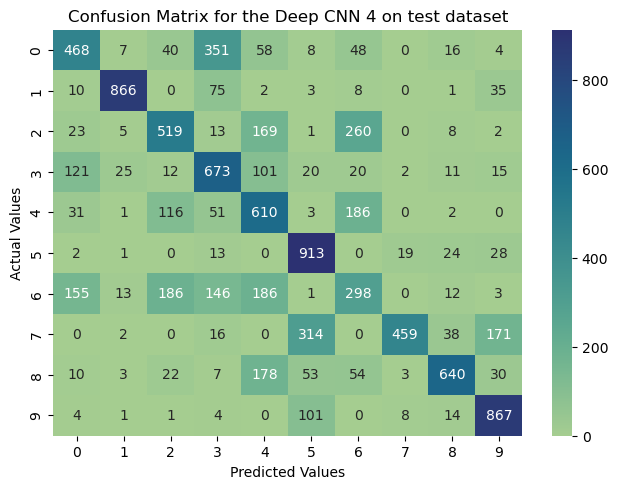

array([[1.1431762e-06, 5.2072787e-06, 4.7412676e-08, ..., 3.6093548e-02,
        1.3308411e-03, 8.7362725e-01],
       [9.9920198e-02, 3.9777678e-05, 1.4979191e-01, ..., 8.8587885e-06,
        4.2686011e-03, 9.9185963e-05],
       [6.0400274e-03, 8.9323133e-01, 2.9979650e-05, ..., 9.1124137e-05,
        1.4332853e-03, 1.0887369e-02],
       ...,
       [5.4580796e-05, 1.5580887e-05, 7.7447956e-05, ..., 2.5521273e-02,
        4.5452222e-01, 3.9009336e-02],
       [1.2204890e-03, 9.5109957e-01, 1.9937943e-06, ..., 1.7797870e-03,
        1.2722687e-04, 1.3220958e-02],
       [9.1368722e-04, 1.8624142e-04, 2.6103175e-05, ..., 8.9060061e-02,
        3.9455333e-01, 6.1947823e-02]], dtype=float32)

In [319]:
EvaluateNeuralNetworkModel(deep_cnn_model4, test_images, test_labels, test_labels_onehot, "Deep CNN 4")

### Deep CNN Model Committee

Loss for the Deep CNN neural network committee on test dataset: 0.2631
Accuracy for the Deep CNN neural network committee on test dataset: 0.9159
first 10 predicted outputs using committee by averaging predictions: [9 2 1 1 6 1 4 6 5 7]

first 10 true outputs: [9 2 1 1 6 1 4 6 5 7]

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.87      0.90      0.88      1000
           3       0.90      0.92      0.91      1000
           4       0.85      0.89      0.87      1000
           5       0.99      0.97      0.98      1000
           6       0.78      0.75      0.76      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg

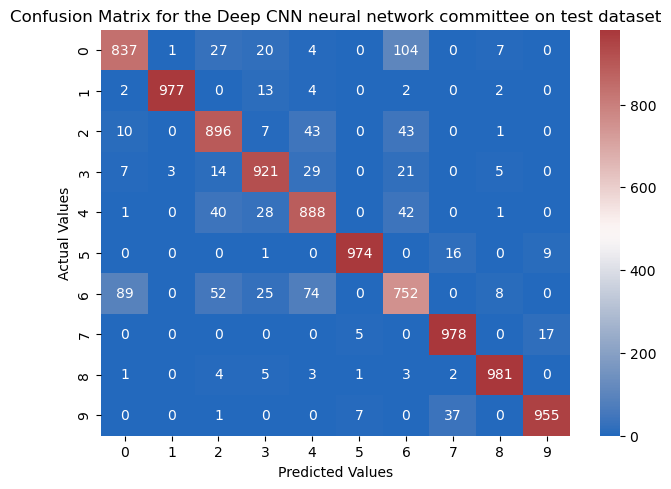

In [320]:
ModelCommitteeAnalysis(
    [deep_cnn1_prediction_result_softmax, 
     deep_cnn2_prediction_result_softmax, 
     deep_cnn3_prediction_result_softmax],
     test_labels,
     "Deep CNN"
)

## Aggregated Committe from Shallow NN, Simple CNN and Deep CNN

### Simple Averaging Technique

### Weighted Averaging Technique

## Please use the Fashion MNIST dataset in Q1 to implement the following network along with batch normalization and dropout layers.

In [353]:
# ann_model = tf.keras.Sequential()
input_layer = tf.keras.layers.Input(shape = (28, 28, 1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
dense_layer1 = tf.keras.layers.Dense(units= 128, activation=  "relu")(flatten_layer)
dense_layer2 = tf.keras.layers.Dense(units= 784, activation=  "relu")(dense_layer1)
dense_layer2_reshaped = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(dense_layer2)
concatenated_layer = tf.keras.layers.Concatenate(axis=-1)([input_layer, dense_layer2_reshaped])
flatten_layer2 = tf.keras.layers.Flatten()(concatenated_layer)
fully_connected_layer = tf.keras.layers.Dense(units= 256, activation= "relu")(flatten_layer)
output_layer = tf.keras.layers.Dense(10, activation='softmax')(fully_connected_layer)

ann_model = tf.keras.Model(
    input_layer,
    output_layer
)

ann_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

ann_model_history = ann_model.fit(X_train, y_train , epochs=100, validation_data= (X_val, y_val), batch_size= 64)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7720 - loss: 0.6671 - val_accuracy: 0.8379 - val_loss: 0.4393
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8525 - loss: 0.4011 - val_accuracy: 0.8512 - val_loss: 0.4188
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8658 - loss: 0.3664 - val_accuracy: 0.8650 - val_loss: 0.3803
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8739 - loss: 0.3412 - val_accuracy: 0.8702 - val_loss: 0.3663
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8816 - loss: 0.3214 - val_accuracy: 0.8674 - val_loss: 0.3745
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8864 - loss: 0.3098 - val_accuracy: 0.8732 - val_loss: 0.3641
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8902 - loss: 0.2998 - val_accuracy: 0.8760 - val_loss: 0.3544
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8941 - loss: 0.2870 - val_accu

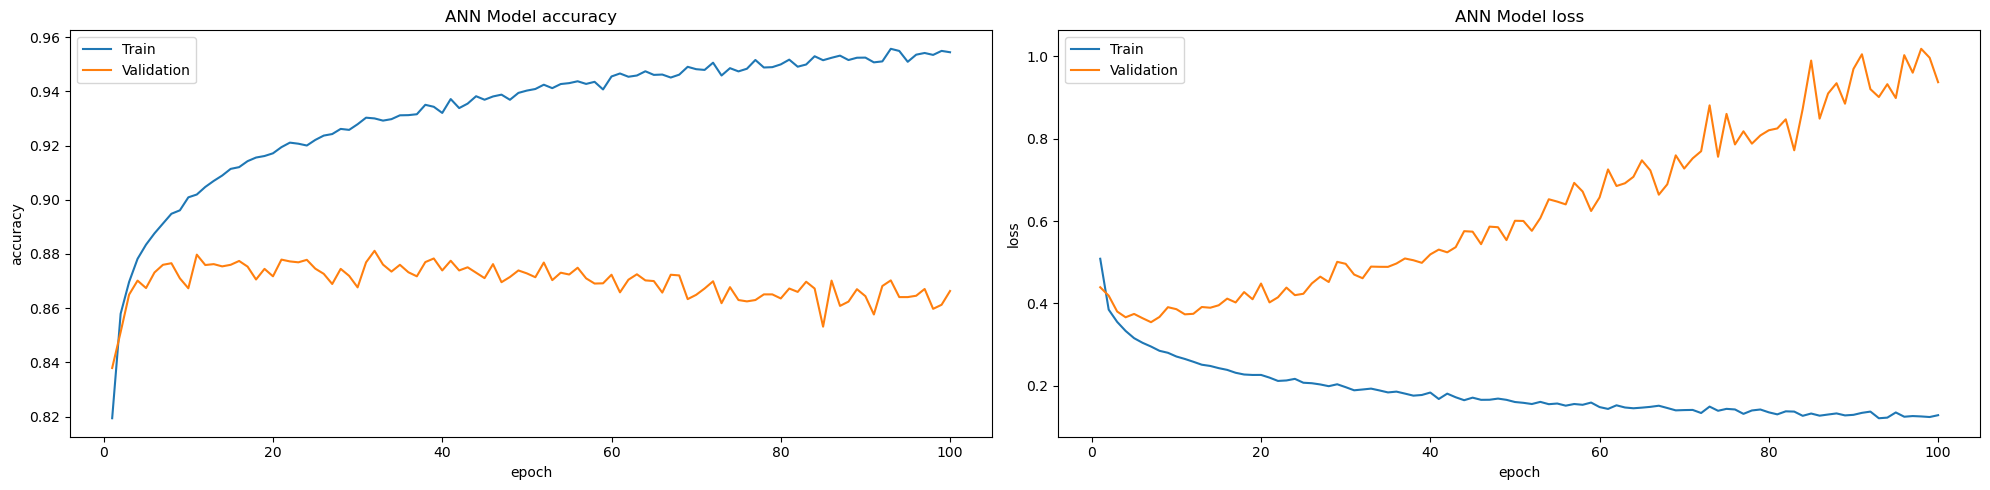

In [355]:
PlotTrainAndValidationAccuracyAndLoss(ann_model_history, "ANN Model")

313/313 - 1s - 3ms/step - accuracy: 0.8620 - loss: 1.0317

Test accuracy for ANN Model: 0.8620

Test loss for ANN Model: 1.0317

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
first 10 predicted outputs: [9 2 1 1 6 1 4 6 5 7]

first 10 true outpurs: [9 2 1 1 6 1 4 6 5 7]

Classification report for ANN Model :
              precision    recall  f1-score   support

           0       0.74      0.85      0.79      1000
           1       0.98      0.97      0.97      1000
           2       0.79      0.72      0.76      1000
           3       0.89      0.82      0.86      1000
           4       0.75      0.81      0.78      1000
           5       0.98      0.95      0.96      1000
           6       0.66      0.62      0.64      1000
           7       0.92      0.97      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86  

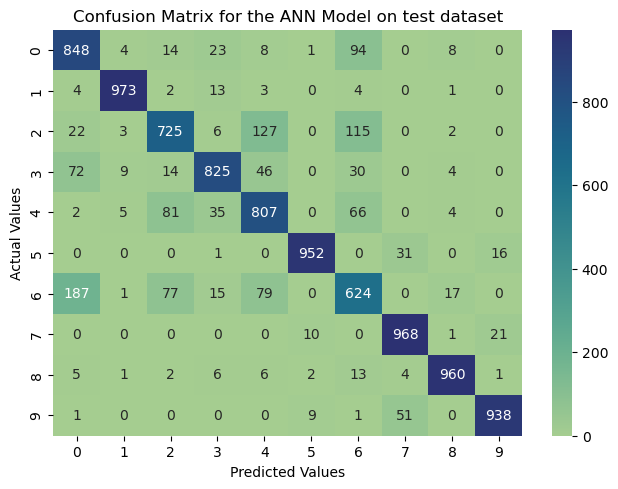

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 2.0733491e-07,
        0.0000000e+00, 9.9999976e-01],
       [3.4129911e-07, 5.7476314e-38, 9.7318000e-01, ..., 0.0000000e+00,
        7.0064923e-45, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 2.9878388e-39, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [8.4935128e-27, 7.9295104e-29, 8.3898605e-18, ..., 1.5320933e-05,
        9.0514089e-12, 4.7544591e-13]], dtype=float32)

In [354]:
EvaluateNeuralNetworkModel(ann_model, test_images, test_labels, test_labels_onehot, "ANN Model")